# Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import logging

In [2]:
# set up logging
logging.basicConfig(level=logging.INFO, 
                   format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('feature_engineering')

In [3]:
# add src directory to path
sys.path.append(os.path.abspath(os.path.join('..')))

In [4]:
# import custom modules
from src.data.preprocess import load_data, save_processed_data
from src.features.feature_processor import FeatureProcessor

In [5]:
# load the raw data
logger.info("Loading raw data...")
train_data = pd.read_csv('../data/raw/train.csv')
test_data = pd.read_csv('../data/raw/test.csv')

2025-03-24 16:36:09,504 - feature_engineering - INFO - Loading raw data...


In [6]:
# Extract IDs
train_ids = train_data['Registration Number']
test_ids = test_data['Registration Number']

In [7]:
# Initialize feature processor with target column name
logger.info("Initializing feature processor...")
processor = FeatureProcessor(target_column='Annual Turnover')

2025-03-24 16:36:10,673 - feature_engineering - INFO - Initializing feature processor...


In [8]:
# Process training data - explicitly extract target first
y_train = train_data['Annual Turnover']
X_train = train_data.drop('Annual Turnover', axis=1)

In [9]:
# Process training data - fit and transform
logger.info("Processing training data...")
X_train_processed = processor.fit_transform(X_train, y_train)

2025-03-24 16:36:13,526 - feature_engineering - INFO - Processing training data...
2025-03-24 16:36:13,527 - FeatureProcessor - INFO - Starting fit_transform process
2025-03-24 16:36:13,529 - FeatureProcessor - INFO - Original feature count: 33
2025-03-24 16:36:13,529 - FeatureProcessor - INFO - Fitting missing value handlers
2025-03-24 16:36:13,527 - FeatureProcessor - INFO - Starting fit_transform process
2025-03-24 16:36:13,529 - FeatureProcessor - INFO - Original feature count: 33
2025-03-24 16:36:13,529 - FeatureProcessor - INFO - Fitting missing value handlers
2025-03-24 16:36:13,551 - FeatureProcessor - INFO - Extracting temporal features
2025-03-24 16:36:13,568 - FeatureProcessor - INFO - Fitting and transforming numeric features
2025-03-24 16:36:13,575 - FeatureProcessor - INFO - Identified 1 binary columns
2025-03-24 16:36:13,576 - FeatureProcessor - INFO - Identified 3 low cardinality columns
2025-03-24 16:36:13,576 - FeatureProcessor - INFO - Identified 3 high cardinality c

In [10]:
# Process test data - transform only
logger.info("Processing test data...")
X_test_processed = processor.transform(test_data)

2025-03-24 16:36:15,728 - feature_engineering - INFO - Processing test data...
2025-03-24 16:36:15,729 - FeatureProcessor - INFO - Starting transform process
2025-03-24 16:36:15,730 - FeatureProcessor - INFO - Applying missing value handlers
2025-03-24 16:36:15,729 - FeatureProcessor - INFO - Starting transform process
2025-03-24 16:36:15,730 - FeatureProcessor - INFO - Applying missing value handlers
2025-03-24 16:36:15,733 - FeatureProcessor - INFO - Imputing 26 numeric features
2025-03-24 16:36:15,739 - FeatureProcessor - INFO - Extracting temporal features
2025-03-24 16:36:15,751 - FeatureProcessor - INFO - Transforming numeric features
2025-03-24 16:36:15,755 - FeatureProcessor - INFO - Transforming categorical features
2025-03-24 16:36:15,836 - FeatureProcessor - INFO - Creating interaction features
2025-03-24 16:36:15,852 - FeatureProcessor - INFO - Transform complete. Final feature count: 20


In [11]:
# Verify feature consistency
train_features = set(X_train_processed.columns)
test_features = set(X_test_processed.columns)

logger.info(f"Training data has {len(train_features)} features")
logger.info(f"Test data has {len(test_features)} features")

2025-03-24 16:36:17,145 - feature_engineering - INFO - Training data has 20 features
2025-03-24 16:36:17,147 - feature_engineering - INFO - Test data has 20 features
2025-03-24 16:36:17,147 - feature_engineering - INFO - Test data has 20 features


In [12]:
# Find common features
common_features = list(train_features.intersection(test_features))
logger.info(f"Common features: {len(common_features)}")

2025-03-24 16:36:18,965 - feature_engineering - INFO - Common features: 20


In [13]:
# Find features only in training data
train_only = list(train_features - test_features)
if train_only:
    logger.warning(f"Features only in training data: {train_only}")

In [14]:
# Find features only in test data
test_only = list(test_features - train_features)
if test_only:
    logger.warning(f"Features only in test data: {test_only}")

In [15]:
# Limit to common features
X_train_final = X_train_processed[common_features]
X_test_final = X_test_processed[common_features]

In [16]:
# Save processed data
logger.info("Saving processed data...")
save_processed_data(
    X_train_final, 
    y_train,
    X_test_final, 
    test_ids, 
    '../data/processed/'
)

logger.info("Feature engineering complete!")

2025-03-24 16:36:24,273 - feature_engineering - INFO - Saving processed data...
2025-03-24 16:36:24,366 - feature_engineering - INFO - Feature engineering complete!


Saved processed training data: (3493, 21)
Saved processed test data: (500, 21)


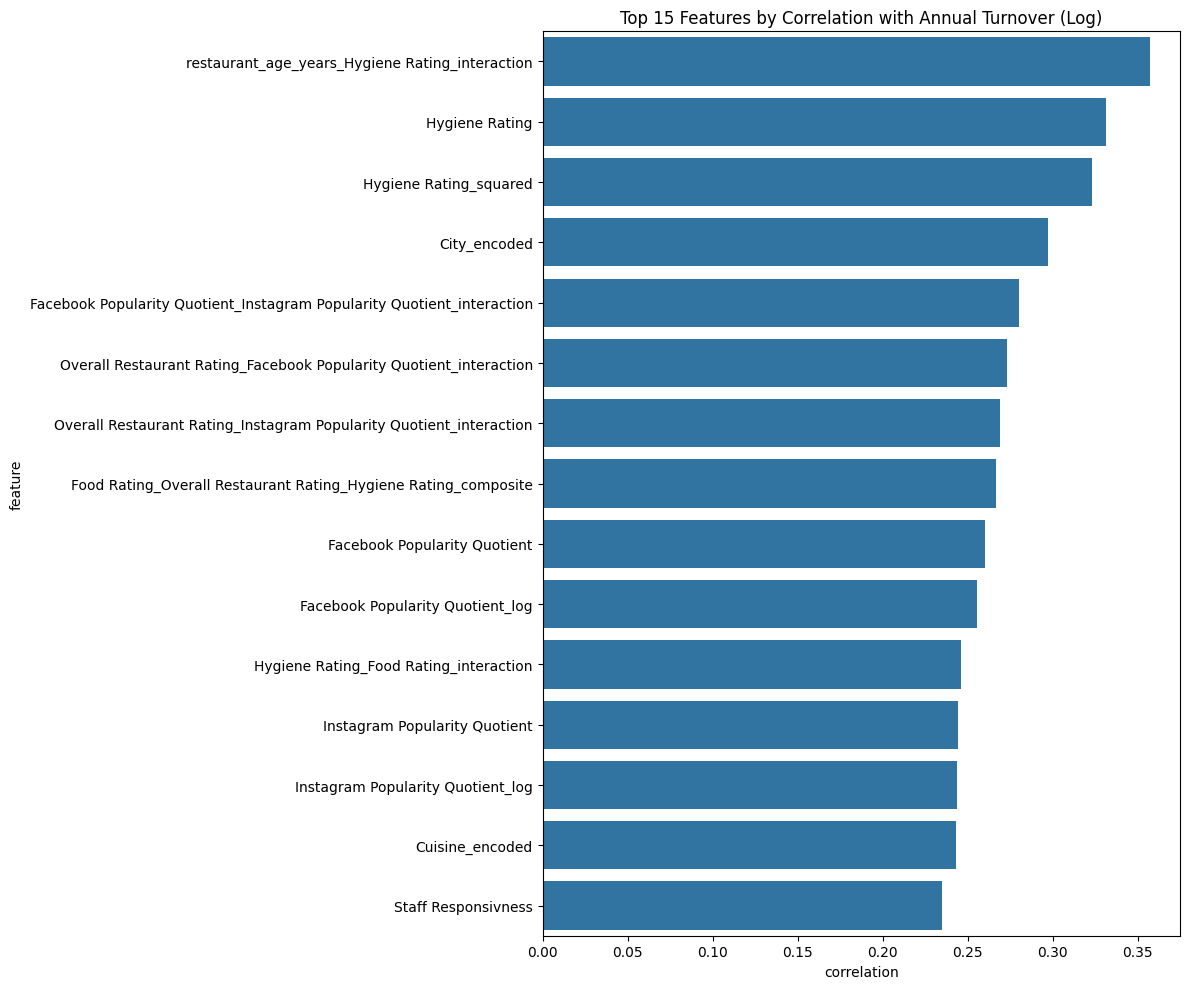

In [17]:
# Visualization for feature importance
try:
    # Correlation with target
    plt.figure(figsize=(12, 10))
    corr_with_target = pd.DataFrame({
        'feature': X_train_final.columns,
        'correlation': [X_train_final[col].corr(np.log1p(y_train)) for col in X_train_final.columns]
    }).sort_values('correlation', ascending=False)
    
    sns.barplot(x='correlation', y='feature', data=corr_with_target.head(15))
    plt.title('Top 15 Features by Correlation with Annual Turnover (Log)')
    plt.tight_layout()
    plt.savefig('../reports/figures/top_feature_correlations.png')
    plt.show()
except Exception as e:
    logger.error(f"Error generating visualizations: {str(e)}")